# Modularer Aufbau der ETL/ML-Pipeline

project/
│
├── weather_pipeline/              # Your current ML pipeline
│   ├── main.py
│   ├── config.py
│   ├── extract.py
|   ├── query_utils.py
│   ├── ...
│
├── gcp_utils/                     # NEW: GCP dataset/table creation utils
│   ├── create_dataset.py         # create_bigquery_dataset()
│   ├── create_table.py           # create_bigquery_table()
│   ├── config.py                 # Optional: GCP-specific config
│   └── main.py                   # Optional runner for GCP setup
│
├── requirements.txt
├── README.md
└── Dockerfile


# ETL/ML Pipeline (weather_pipeline/)

In [ ]:
# Import libraries
import os
import sys
from google.colab import auth
# Authenticate user
auth.authenticate_user()

# Create project direction
project_dir = "/content/weather_pipeline"
os.makedirs(project_dir, exist_ok=True)
# Make sure the path is in sys.path
sys.path.append(project_dir)

# Generate .py files
# config.py
config_code = """
def get_config():
    return {
        "project_id": "etl-weather-467607",
        "dataset": "etl_weather_dataset_siegburg_2024_hourly_daily",
        "table_daily": "daily_weather_siegburg",
        "dataset_pred": "etl_weather_dataset_siegburg_2024_predictions",
        "table_pred": "siegburg_pred_lin_regression_2024-2025",

        # Optional SQL query config
        "custom_query_config": {
            "columns": "time, temperature_2m_max, temperature_2m_min, precipitation_sum",
            "filters": "temperature_2m_max IS NOT NULL",
            "order_by": "time DESC"
        }
    }
"""

# Save to file
with open(f"{project_dir}/config.py", "w") as f:
    f.write(config_code)


# extract.py — generate and save inside /content/weather_pipeline
extract_code = """
import pandas as pd
from google.cloud import bigquery
from query_utils import query_bigquery

def extract_daily_data(project_id, dataset, table_daily):
    '''Default full extract.'''
    client = bigquery.Client(project=project_id)
    table_ref = f"{project_id}.{dataset}.{table_daily}"
    query = f"SELECT * FROM `{table_ref}`"
    df = client.query(query).to_dataframe()
    return df

def extract_hourly_data(project_id, dataset, table_daily):
    '''Default full extract.'''
    client = bigquery.Client(project=project_id)
    table_ref = f"{project_id}.{dataset}.{table_daily}"
    query = f"SELECT * FROM `{table_ref}`"
    df = client.query(query).to_dataframe()
    return df

def extract_with_query(project_id, dataset, table, columns="*", filters=None, order_by=None):
    '''Flexible extract using custom query.'''
    client = bigquery.Client(project=project_id)
    query = query_bigquery(project_id, dataset, table, columns, filters, order_by)
    df = client.query(query).to_dataframe()
    return df
"""

# Save to file
with open(f"{project_dir}/extract.py", "w") as f:
    f.write(extract_code)


# transform.py — generate and save inside /content/weather_pipeline
extract_code = """
import pandas as pd
from google.cloud import bigquery

def transform_daily_data(df):
    df['date'] = pd.to_datetime(df['time']).dt.date
    df = df.rename(columns={
        "temperature_2m_max": "temp_max",
        "temperature_2m_min": "temp_min",
        "precipitation_sum": "precip_total"
    })
    df = df.dropna(subset=['temp_max', 'temp_min', 'precip_total'])
    return df[['date', 'temp_max', 'temp_min', 'precip_total']]
"""

# Save to file
with open(f"{project_dir}/transform.py", "w") as f:
    f.write(extract_code)


# load.py — generate and save inside /content/weather_pipeline
extract_code = """
import pandas as pd
from google.cloud import bigquery

def load_to_bigquery(df, project_id, dataset, table):
    client = bigquery.Client(project=project_id)
    table_ref = f"{project_id}.{dataset}.{table}"
    job = client.load_table_from_dataframe(df, table_ref)
    job.result()
    print(f"Loaded {job.output_rows} rows to {table_ref}")
"""

# Save to file
with open(f"{project_dir}/load.py", "w") as f:
    f.write(extract_code)


# train.py — generate and save inside /content/weather_pipeline
extract_code = """
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def train_model(df):
    X = df[['temp_min', 'precip_total']]
    y = df['temp_max']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = LinearRegression().fit(X_train, y_train)
    return model, X_test, y_test
"""

# Save to file
with open(f"{project_dir}/train.py", "w") as f:
    f.write(extract_code)


# predict.py — generate and save inside /content/weather_pipeline
extract_code = """
import pandas as pd

def predict(model, X_test, y_test, df_transformed):
    y_pred = model.predict(X_test)
    return pd.DataFrame({
        'date': df_transformed.loc[X_test.index, 'date'],
        'temp_max': y_test,
        'pred_temp_max': y_pred
    })
"""

# Save to file
with open(f"{project_dir}/predictor.py", "w") as f:
    f.write(extract_code)


# visualize.py — generate and save inside /content/weather_pipeline
extract_code = """
import matplotlib.pyplot as plt

def plot_predictions(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['date'], df['temp_max'], label='Actual')
    plt.scatter(df['date'], df['pred_temp_max'], label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Max Temperature')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
"""

# Save to file
with open(f"{project_dir}/visualize.py", "w") as f:
    f.write(extract_code)

# query_utils.py — generate and save inside /content/weather_pipeline
extract_code = """
def query_bigquery(
    project_id,
    dataset_id,
    table_id,
    columns="*",
    filters=None,
    order_by=None,
):
    '''Build a flexible SQL query for a BigQuery table.'''
    query = f"SELECT {columns} FROM `{project_id}.{dataset_id}.{table_id}`"

    if filters:
        query += f" WHERE {filters}"
    if order_by:
        query += f" ORDER BY {order_by}"

    return query

    # query_utils.py

def build_query(project, dataset, table, columns="*", filters=None, order_by=None):
    '''Builds a flexible SQL query for a BigQuery table.'''
    query = f"SELECT {columns} FROM `{project}.{dataset}.{table}`"

    if filters:
        query += f" WHERE {filters}"

    if order_by:
        query += f" ORDER BY {order_by}"

    return query

def prompt_user_for_query():
    '''Prompts the user for custom query parameters.'''
    print("Customize your BigQuery query (leave blank to skip)")

    columns = input("Columns to select (default '*'): ").strip() or "*"
    filters = input("WHERE clause (e.g., temp_max > 30): ").strip() or None
    order_by = input("ORDER BY clause (e.g., date DESC): ").strip() or None

    return {
        "columns": columns,
        "filters": filters,
        "order_by": order_by
    }

"""

# Save to file
with open(f"{project_dir}/query_utils.py", "w") as f:
    f.write(extract_code)

# main.py — generate and save inside /content/weather_pipeline
main_code = """
from config import get_config
from extract import extract_daily_data, extract_with_query
from transform import transform_daily_data
from train import train_model
from predict import predict
from visualize import plot_predictions
from load import load_to_bigquery
from query_utils import build_query, prompt_user_for_query


def main():
    config = get_config()
    project = config["project_id"]
    dataset = config["dataset"]
    table = config["table_daily"]

    # Option: Use user-defined query
    use_prompt = input("Use custom query? (yes/no): ").strip().lower() == "yes"

    if use_prompt:
        query_params = prompt_user_for_query()
        query = build_query(
            project=project,
            dataset=dataset,
            table=table,
            columns=query_params["columns"],
            filters=query_params["filters"],
            order_by=query_params["order_by"]
        )
        df_raw = extract_with_query(project, query)
    else:
        # Use config-driven query or default full-table read
        custom_query = config.get("custom_query_config", None)

        if custom_query:
            df_raw = extract_with_query(
                project,
                build_query(
                    project,
                    dataset,
                    table,
                    columns=custom_query.get("columns", "*"),
                    filters=custom_query.get("filters"),
                    order_by=custom_query.get("order_by")
                )
            )
        else:
            df_raw = extract_daily_data(project, dataset, table)

    # Continue ETL
    df_trans = transform_daily_data(df_raw)
    model, X_test, y_test = train_model(df_trans)
    df_pred = predict(model, X_test, y_test, df_trans)
    plot_predictions(df_pred)
    load_to_bigquery(df_pred, project, config["dataset_pred"], config["table_pred"])

if __name__ == "__main__":
    main()

"""

# Save to file
with open(f"{project_dir}/main.py", "w") as f:
    f.write(main_code)


# dockerfile — generate and save inside /content/weather_pipeline
dockerfile_code = """
FROM python:3.10-slim

WORKDIR /app

COPY . .

RUN pip install --no-cache-dir -r requirements.txt

CMD ["python", "main.py"]
"""

# Save to file
with open(f"{project_dir}/Dockerfile", "w") as f:
    f.write(dockerfile_code)


# requirements.txt — generate and save inside /content/weather_pipeline
requirements_code = '''
pandas
matplotlib
scikit-learn
google-cloud-bigquery
'''

with open(f"{project_dir}/requirements.txt", "w") as f:
    f.write(requirements_code)

readme_code = """
# Weather Forecasting ETL Pipeline

This project extracts weather data, transforms it, trains a regression model to predict max temperatures, and loads results into BigQuery.

## Modules

- `config.py`: Configuration settings
- `extract.py`: Extract from BigQuery
- `transform.py`: Data cleaning
- `train.py`: Linear regression model
- `predict.py`: Predictions
- `visualize.py`: Plots
- `load.py`: Load predictions to BigQuery
- `main.py`: Pipeline runner

## Requirements

- Google Cloud credentials
- Python 3.7+
"""

with open(f"{project_dir}/README.md", "w") as f:
    f.write(readme_code)

# GCP Ressource Management (gcp_utils/ or gcloud_admin/)

In [ ]:
# Import libraries
import os
import sys
from google.colab import auth

# Create gcp utilization direction
gcp_utils_dir = "/content/gcp_utils"
os.makedirs(gcp_utils_dir, exist_ok=True)
# Make sure the path is in sys.path
sys.path.append(gcp_utils_dir)

# Set project id
PROJECT_ID = "etl-weather-467607"
# Authenticate user on the google cloud project id
auth.authenticate_user(project_id=PROJECT_ID)

# Generate .py files
# create_dataset.py - generate and save inside /content/gcp_utils
extract_code = """
from google.cloud import bigquery

def create_dataset(PROJECT_ID, dataset_id, location="EU"):
    # Creates a BigQuery dataset if it doesn't exist.
    client = bigquery.Client(project=PROJECT_ID)
    dataset_ref = client.dataset(dataset_id)
    try:
        client.get_dataset(dataset_ref)
        print(f"Dataset '{dataset_id}' already exists.")
    except:
        dataset = bigquery.Dataset(dataset_ref)
        dataset.location = location
        client.create_dataset(dataset)
        print(f"Dataset '{dataset_id}' created.")
"""

# Save to file
with open(f"{gcp_utils_dir}/create_dataset.py", "w") as f:
    f.write(extract_code)


# create_table.py - generate and save inside /content/gcp_utils
extract_code = """
from google.cloud import bigquery

def create_table(PROJECT_ID, dataset_id, table_id):

    # Creates a BigQuery table if it doesn't exist.
    client = bigquery.Client(project=PROJECT_ID)
    dataset_ref = client.dataset(dataset_id)
    table_ref = dataset_ref.table(table_id)
    try:
        client.get_table(table_ref)
        print(f"Table '{table_id}' already exists.")
    except:
        # table = bigquery.Table(table_ref, schema=schema)
        table = bigquery.Table(table_ref)
        client.create_table(table)
        print(f"Table '{table_id}' created.")
"""

# Save to file
with open(f"{gcp_utils_dir}/create_table.py", "w") as f:
    f.write(extract_code)


# job_tables.py - generate and save inside /content/gcp_utils
extract_code = """
from google.cloud import bigquery

def job_tables(PROJECT_ID, dataset_id, table_id, df):
    # Create BigQuery Instance, Datasets, Tables.
    # Loads a pandas DataFrame into a BigQuery table.
    client = bigquery.Client(project=PROJECT_ID)                                # create instance of bigquery.Client class, project argument specifies the Google Cloud project ID
    table_ref = f"{PROJECT_ID}.{dataset_id}.{table_id}"
    job = client.load_table_from_dataframe(df, table_ref)                       # Start a BigQuery load job from a DataFrame
    job.result()                                                                # Wait for the load job to complete
    print(f"{job.output_rows} Zeilen nach BigQuery geladen.")                   # Print the number of rows loaded
"""

# Save to file
with open(f"{gcp_utils_dir}/job_tables.py", "w") as f:
    f.write(extract_code)



# gcp_utils/main.py - generate and save inside /content/gcp_utils
extract_code = """
from gcp_utils.create_dataset import create_dataset
from gcp_utils.create_table import create_table

def main(project, dataset, table):
    create_dataset(project, dataset)
    create_table(project, dataset, table)

if __name__ == "__main__":
    # You can provide default values here, or leave it empty
    main("etl-weather-467607", "default_dataset", "default_table")
"""

# Save to file
with open(f"{gcp_utils_dir}/manage_gcp.py", "w") as f:
    f.write(extract_code)

# Run the Pipeline-Script

Use custom query? (yes/no): yes


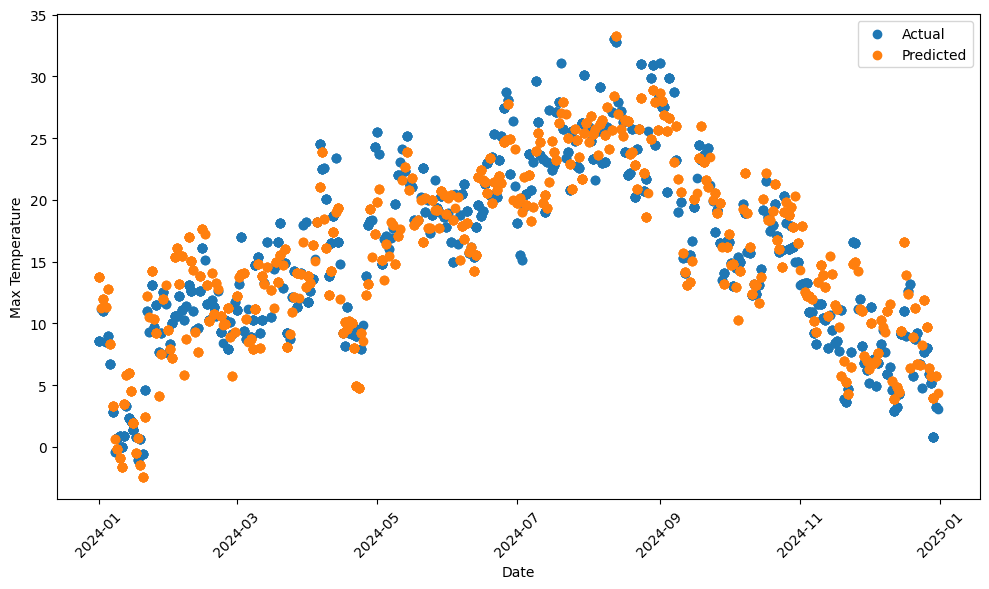

Loaded 1757 rows to etl-weather-467607.etl_weather_dataset_siegburg_2024_predictions.siegburg_pred_lin_regression_2024-2025


In [ ]:
# # Option 1: Run main.py in a subprocess (like a real script)
# !python3 {project_dir}/main.py

# Option 2: Import and call main() directly
sys.path.append(project_dir)
use_custom_query = input("Use custom query? (yes/no): ").strip().lower() == "yes"

from main import main
main()


# Run Creation Dataset/Table Script

In [ ]:
import sys
gcp_utils_dir = "/content/gcp_utils"

# Add gcp_utils to the front of the search path to give it priority
if gcp_utils_dir not in sys.path:
    sys.path.insert(0, gcp_utils_dir)

import importlib
import manage_gcp
importlib.reload(manage_gcp)

print(manage_gcp.__file__)  # Verify it's the correct path

# Call the function with your parameters
manage_gcp.main("etl-weather-467607", "etl_weather_dataset_siegburg_2024_hourly_daily", "hourly_weather_siegburg")

/content/gcp_utils/manage_gcp.py
Dataset 'etl_weather_dataset_siegburg_2024_hourly_daily' already exists.
Table 'hourly_weather_siegburg' already exists.


# Dockerize the Project Later

You don't need it right now, but when you're ready to containerize, here’s a simple base Dockerfile:

In [ ]:
# dockerfile_code = """
# FROM python:3.10-slim

# WORKDIR /app

# COPY . .

# RUN pip install --no-cache-dir -r requirements.txt

# CMD ["python", "main.py"]
# """

# with open(f"{project_dir}/Dockerfile", "w") as f:
#     f.write(dockerfile_code)


# Historical Weather Data 2024, Siegburg, DEU, hourly, daily:

https://archive-api.open-meteo.com/v1/archive?latitude=50.8002&longitude=7.2077&start_date=2024-01-01&end_date=2024-12-31&daily=weather_code,temperature_2m_mean,temperature_2m_max,apparent_temperature_mean,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,sunrise,sunset,daylight_duration,sunshine_duration,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration&hourly=temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m,soil_temperature_0_to_7cm,soil_temperature_28_to_100cm,soil_temperature_7_to_28cm,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm&models=best_match&timezone=Europe%2FBerlin